In [363]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os, sys, json, random, string, re
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

import nltk
#nltk.download('stopwords')

files = os.listdir("./data")

json_data = pd.DataFrame(columns=['src_lang', 'text', 'file_name', 'meme_id'])

for index, js in enumerate(files):
    with open(os.path.join('./data', js)) as json_file:
        json_text = json.load(json_file)
        src_lang = json_text['src_lang']
        text = json_text['text']
        file_name = json_text['file_name']
        meme_id = json_text['id']
        json_data.loc[index] = [src_lang, text, file_name, meme_id]

def clean_column(data):
    if data is not None:
        stopword_list = stopwords.words('english')
        data = data.lower()
        data = re.sub(r"\n", " ", data)
        data = re.sub(r"i'm", "i am", data)
        data = re.sub(r"\'re", " are", data)
        data = re.sub(r"\'d", " would", data)
        data = re.sub(r"\'ve", " have", data)
        data = re.sub(r"\'ll", " will", data)
        data = re.sub(r"can't", "cannot", data)
        data = re.sub(r"thats", "that is", data)
        data = re.sub(r"that's", "that is", data)
        data = re.sub(r"hes", "he is", data)
        data = re.sub(r"shes", "she is", data)
        data = re.sub(r"\'s", " is", data)
        data = re.sub(r"n't", " not", data)
        data = re.sub(r"ur", "you are", data)
        data = re.sub(r"u r", "you are", data)
        data = re.sub(r"[0-9]+", "", data)
        data = re.sub(r"[^\w\s]", "", data)
        return data

json_data['text'] = json_data['text'].apply(clean_column)


In [364]:
stopwords = set(STOPWORDS)
stopwords.add('will')
stopwords.add('yoyou')
stopwords.add('rdankmemes')
stopwords.add('meme')
stopwords.add('memes')
stopwords.add('hoyou')

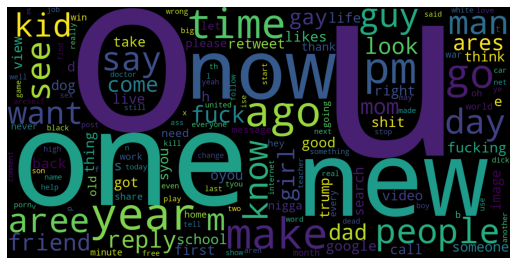

In [365]:
wordcloud = WordCloud(
    collocations = False,
    width=1600, height=800,
    stopwords=stopwords,
    max_words=150,
    random_state=42
).generate(' '.join(json_data['text']))


print(wordcloud)
plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [366]:
stemmer = PorterStemmer()
def stemming_tokenizer(input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [367]:
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokensize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [368]:
data = json_data['text']
tf_idf_vectorizer = TfidfVectorizer(stop_words=stopwords, max_features=1000)
tf_idf = tf_idf_vectorizer.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_arr = tf_idf_norm.toarray()
print(len(tf_idf_arr))
pd.DataFrame(tf_idf_arr, columns=tf_idf_vectorizer.get_feature_names()).head()

3031


/home/skuretski/anaconda3/envs/cs410/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,able,abortion,accidentally,account,act,actually,ad,add,address,adult,...,yeah,year,years,yes,yet,yo,york,young,youtube,ме
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.136703,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


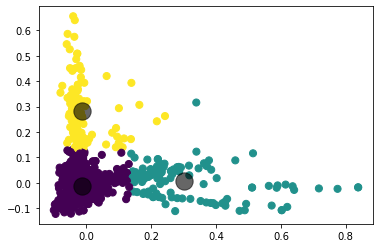

In [369]:
num_clusters = 3

sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_arr)

kmeans = KMeans(n_clusters= num_clusters, max_iter=600, algorithm = 'full')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction ,s=50, cmap='viridis')

centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=300, alpha=0.6);

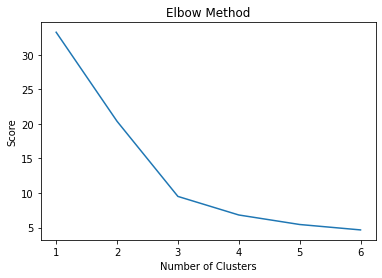

In [370]:
number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score = [i*-1 for i in score]

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.7957157605316943
For n_clusters = 3 The average silhouette_score is : 0.8205279874429291
For n_clusters = 4 The average silhouette_score is : 0.7961790966907853
For n_clusters = 5 The average silhouette_score is : 0.7325161055439335
For n_clusters = 6 The average silhouette_score is : 0.4232389382541805


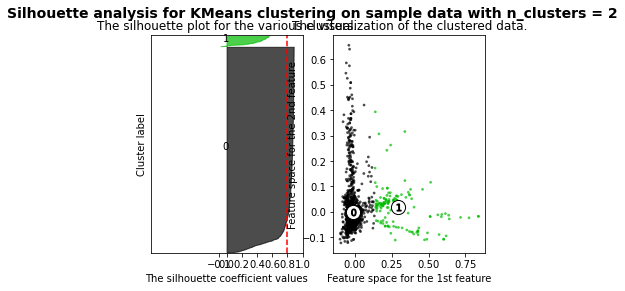

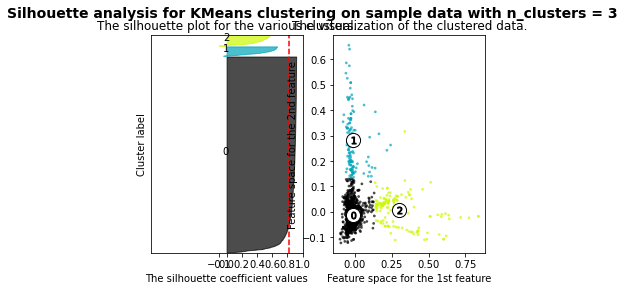

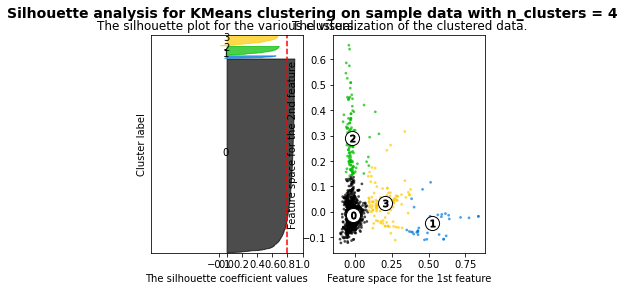

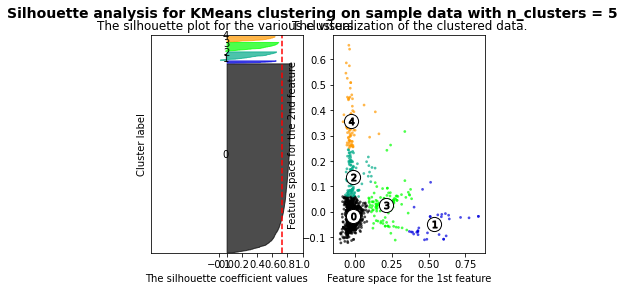

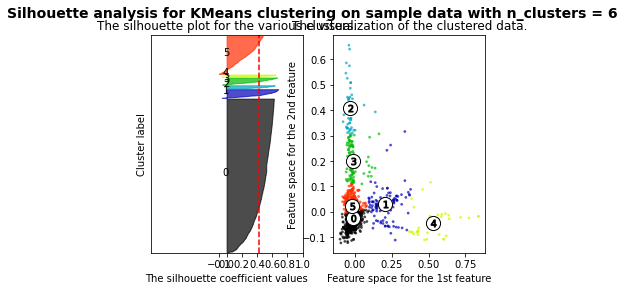

In [377]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from [-1, 1] 
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(Y_sklearn) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(Y_sklearn)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(Y_sklearn, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Y_sklearn, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()
    

In [379]:
def get_top_features_cluster(tf_idf_arr, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_arr[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_arr, prediction, 20)

<AxesSubplot:xlabel='score', ylabel='features'>

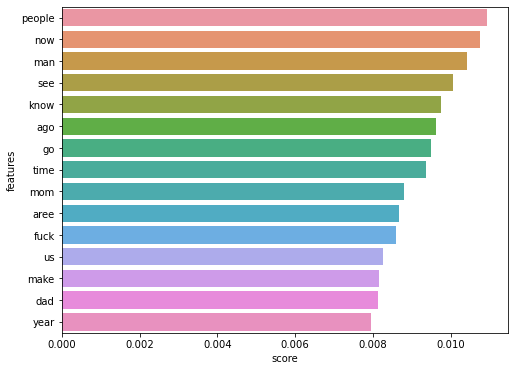

In [380]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[0][:15])

<AxesSubplot:xlabel='score', ylabel='features'>

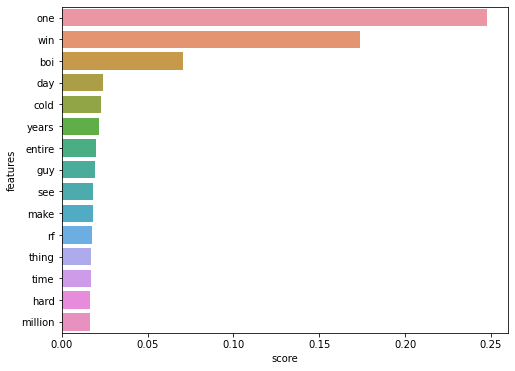

In [381]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:15])

<AxesSubplot:xlabel='score', ylabel='features'>

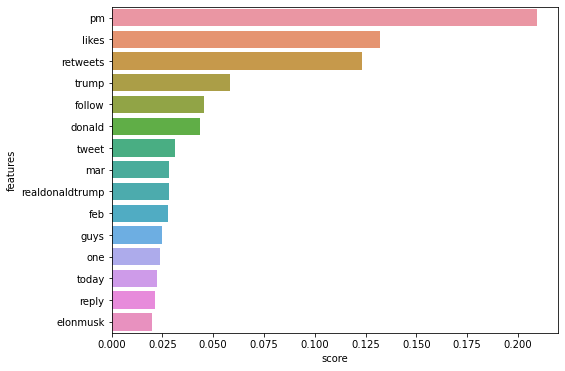

In [382]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[2][:15])